<a href="https://colab.research.google.com/github/escaduto/DamageAssessment/blob/master/%5B2%5DBuildingDamage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
rootPath = '/content/drive/My Drive/BuildingDamage_Model'
os.chdir(rootPath)

In [ ]:
import IPython.display as ipd
from scipy.io import wavfile

soundfile1 = 'Metal_Gong.wav'
soundfile2 = 'Warbling.wav'

In [ ]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext): 
              file_list.append(os.path.join(path, names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath + "/"

## Import Packages

In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import rtree

### Building Footprints

In [ ]:
%ls 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly'

In [ ]:
predicted_lst = lstFiles('data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly', '.geojson')
predicted_buildings = gpd.read_file(predicted_lst[0])

In [ ]:
# add fire name, fire year 
print(predicted_lst[0])
predicted_buildings

### FRAP Fire Perimeters

In [ ]:
fire_perimeters = gpd.read_file('data/FRAP_Perimeters/FRAP_2012_2019.shp')

In [ ]:
fire_perimeters

### Structural Damage Data

In [ ]:
damage_file = lstFiles('data/All_Incidents_2013_2019_DINS_GDB', 'gdb')

In [ ]:
damage_gdb = gpd.read_file('data/All_Incidents_2013_2019_DINS_GDB/All_Incidents_2013_2019_DINS_GDB/All_Incidents_2013_2019_DINS_GDB.gdb')

In [ ]:
damage_gdb.columns

Index(['DAMAGE', 'STREETNUMBER', 'STREETNAME', 'STREETTYPE', 'STREETSUFFIX',
       'CITY', 'STATE', 'ZIPCODE', 'CALFIREUNIT', 'COUNTY', 'COMMUNITY',
       'BATTALION', 'INCIDENTNAME', 'INCIDENTNUM', 'INCIDENTSTARTDATE',
       'HAZARDTYPE', 'WHEREFIRESTARTEDONSTRUCTURE', 'WHATDIDFIRESTARTFROM',
       'DEFENSIVEACTIONS', 'PROPANETANKDISTANCE', 'STRUCTURETYPE',
       'STRUCTURECATEGORY', 'NUMBEROFUNITPERSTRUCTURE',
       'NONHABITABLEOUTBUILDINGS', 'NOOUTBUILDINGSDAMAGED',
       'NOOUTBUILDINGSNOTDAMAGED', 'ROOFCONSTRUCTION', 'EAVES', 'VENTSCREEN',
       'EXTERIORSIDING', 'WINDOWPANE', 'DECKPORCHONGRADE', 'DECKPORCHELEVATED',
       'PATIOCOVERCARPORT', 'FENCEATTACHEDTOSTRUCTURE',
       'UTILITYMISCSTRUCTUREDISTANCE', 'FIRENAME', 'APN',
       'ASSESSEDIMPROVEDVALUE', 'YEARBUILT', 'SITEADDRESS_PFIS', 'GLOBALID',
       'Total_Text', 'Latitide', 'Longitude', 'geometry'],
      dtype='object')

### Basic Stats

pie charts: https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

In [ ]:
print('Damage Classes: ', damage_gdb.DAMAGE.unique().tolist())
print('Fire Incidences: ', len(damage_gdb.INCIDENTNAME.unique().tolist()), damage_gdb.INCIDENTNAME.unique().tolist())
print('Structure Classes: ', len(damage_gdb.STRUCTURECATEGORY.unique()), damage_gdb.STRUCTURECATEGORY.unique().tolist())
print('STRUCTURETYPE: ', len(damage_gdb.STRUCTURETYPE.unique()), damage_gdb.STRUCTURETYPE.unique().tolist())
print('Fire Date: ', len(damage_gdb.INCIDENTSTARTDATE.unique().tolist()), damage_gdb.INCIDENTSTARTDATE.unique().tolist())
print('HAZARDTYPE: ', damage_gdb.HAZARDTYPE.unique().tolist())

Damage Classes:  ['Destroyed (>50%)', 'Affected (1-9%)', 'Major (26-50%)', 'Minor (10-25%)', 'No Damage', 'Inaccessible']
Fire Incidences:  110 ['Camp', 'Woolsey', 'Hill', 'Stoll', 'Pawnee', 'Ranch', 'River', 'Klamathon', 'Cranston', 'Carr', 'Holy', 'Grant', 'Frazier', 'Creek', 'Horse', 'Hyatt', 'Waverly', 'Ruby', 'County', 'West', 'Ridge', 'Irish', 'Nicolaus', 'Colusa', 'Vista', 'Carder', 'Spring', 'Marsh', 'Steele', 'Omega', 'Wagner', 'Delta', 'Meyers', 'Richmond', 'Holiday', 'Silver', 'Calgary', 'Ponderosa', 'Estate', 'Atlas', 'Nuns', 'Tubbs', 'Thomas', 'Pocket', 'Skirball', 'Bear', 'Cocos', 'Valley', 'Butte', 'Cascade', 'Clayton', 'Chimney', 'Sulphur', 'Black', 'Boles', 'Erskine', 'Soberanes', 'Tassajara', 'Round', 'Rocky', 'Stone', 'Alamo', 'Laverne', 'Whittier', 'Owens_River', 'Loma', 'Grade', 'Foothill', 'Thirty_Seven', 'Lilac', 'Mission', 'Peak', 'Detwiler', 'Redwood', 'Wall', 'Canyon_2', 'Cherokee', 'Laporte', 'McCourtney', 'Lobo', 'Spenceville', 'Pleasant', 'Helena', 'Goose',

In [ ]:
# drop inaccessible 
damage_gdb = damage_gdb[damage_gdb['DAMAGE'] != 'Inaccessible']

In [ ]:
groupedbyDamage = damage_gdb.groupby(['DAMAGE']).count().reset_index()
groupedbyDamage = groupedbyDamage[['DAMAGE', 'INCIDENTNUM']]
groupedbyDamage = groupedbyDamage.sort_values(by='INCIDENTNUM', ascending=True)
groupedbyDamage

DAMAGE  INCIDENTNUM
2    Major (26-50%)          351
3    Minor (10-25%)          662
0   Affected (1-9%)         2103
4         No Damage         6163
1  Destroyed (>50%)        38696

##Spatial Join Predicted to damage

In [ ]:
predicted_lst[-7:]

['data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/Kincade_PredictedBuildings.geojson',
 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/Valley_PredictedBuildings.geojson',
 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/Camp_PredictedBuildings.geojson',
 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/Carr_PredictedBuildings.geojson',
 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/County_PredictedBuildings.geojson',
 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/Ranch_PredictedBuildings.geojson',
 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/Thomas_PredictedBuildings.geojson']

In [ ]:
from shapely.affinity import translate
from shapely.geometry import Polygon
import geopandas

damage_gdb = gpd.read_file('data/All_Incidents_2013_2019_DINS_GDB/All_Incidents_2013_2019_DINS_GDB/All_Incidents_2013_2019_DINS_GDB.gdb')

for poly in predicted_lst[-7:]: 
  # Get the filename only from the initial file path.
  filename = os.path.basename(poly)
  fire_nm = filename.split('_')[0]

  # get only damage points based on fire name, keep only damage attribute 
  damage_lyer = damage_gdb[damage_gdb['INCIDENTNAME'] == fire_nm]
  damage_lyer = damage_lyer[['DAMAGE', 'geometry']]
      
  print(filename, fire_nm)

  predicted_buildings = gpd.read_file(poly)
  print('checking crs...')
  predicted_buildings = predicted_buildings.to_crs(damage_gdb.crs) 
  
  print('buffering geometries...')
  poly_buff = predicted_buildings.buffer(0.5)
  damage_lyer['geometry'] = damage_lyer.geometry.buffer(10)
  
  print('dissolving overlaping geometries...')
  geoms = poly_buff.geometry.unary_union
  print('recreating new multipoly geometries...')
  df = gpd.GeoDataFrame(geometry=[geoms])
  geoms_multi = df.geometry.explode().reset_index()
  geoms_multi = geoms_multi.set_crs(damage_gdb.crs)

  print('spatial joining...')
  poly_dam = gpd.sjoin(geoms_multi, damage_lyer, how="left", op='intersects')
  poly_dam['INCIDENTNAME'] = fire_nm
  
  # where 'damage is null change to 'No Damage' 
  poly_dam = poly_dam.fillna(value={'DAMAGE':'No Damage'}).drop(columns=['level_1', 'level_0', 'index_right'])

  print('saving file...')
  poly_dam.to_file(os.path.join('data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly_attr', filename), driver='GeoJSON')

In [ ]:
maploc = folium.Map(location=[38.391934, -122.230672],zoom_start=12,tiles="Stamen Toner")

folium.GeoJson(
    poly_buff,
    style_function=lambda feature: {
        'fillColor': '#ffdecf',
          'color' : '#900d0d',
          'weight' : 1,
          'fillOpacity' : 0.5
        }
    ).add_to(maploc)

maploc

In [ ]:
poly_dam

## Merged all predicted w/ attributes 

In [ ]:
poly_list = lstFiles('data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly_attr', '.geojson')
poly1 = gpd.read_file(poly_list[0])
poly2 = gpd.read_file(poly_list[1])
merged = poly1.append(poly2)
for i, poly in enumerate(poly_list[2:]):
  poly3 = gpd.read_file(poly_list[i])
  merged = merged.append(poly3)
merged.to_file(f"data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly_attr_all/PredictedBuildings_attr.shp")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


In [ ]:
import numpy as np
merged['class'] = np.where(merged['DAMAGE']=='No Damage', 0, 1)
merged.to_file(f"data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly_attr_all/PredictedBuildings_attr.shp")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until


### Add into bucket & load to assets

In [ ]:
! gsutil -m cp -R 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly_attr_all/' gs://buildingassessment

In [ ]:
! earthengine upload table --asset_id=users/escaduto/BuildingAssessment/PredictedFootprints_attr gs://buildingassessment/poly_attr_all/PredictedBuildings_attr.shp

## POST-FIRE NAIP
Get NAIP based on incident date

In [ ]:
# initialize and connect to GEE 
from google.colab import auth
auth.authenticate_user()
!earthengine authenticate
import ee 
ee.Initialize()

In [ ]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

In [ ]:
import pandas as pd
combined_csv = pd.read_csv("data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/combined_csvEval.csv")
combined_csv

In [ ]:
filt_by_score = combined_csv[(combined_csv['Precision'] > 0.5) & (combined_csv['Year'] < 2019)]
#list(zip(filt_by_score['Fire'], filt_by_score['Year']))

In [ ]:
fire_list = ['Atlas',
 'Boles',
 'Canyon',
 'Canyon_2',
 'Carr',
 'Cascade',
 'Chimney',
 'Clayton',
 'Clover',
 'Creek',
 'Detwiler',
 'Erskine',
 'Helena',
 'Holiday',
 'Holy',
 'Klamathon',
 'Laporte',
 'Laverne',
 'Lilac',
 'Lobo',
 'Mission',
 'Nuns',
 'Pawnee',
 'Pocket',
 'Redwood',
 'Round',
 'Silver',
 'Skirball',
 'Stoll',
 'Sulphur',
 'Thomas',
 'Tubbs',
 'Valley',
 'Vista',
 'Wall',
 'West']

In [ ]:
len(fire_list) # get bounds and incident dates based on these fire list

36

In [ ]:
import geopandas as gpd
outpath = os.path.join('data', 'boundingbox_byfire')
bounds_gdf = gpd.read_file(os.path.join(outpath, 'boundingbox_byfire.geojson'), driver='GeoJSON')

In [ ]:
fire_bounds = bounds_gdf[bounds_gdf['Fire'].isin(fire_list)]
fire_bounds[fire_bounds['Year'] == 2013]

Fire  ...                                           geometry
14  Clover  ...  POLYGON ((-122.53872 40.44418, -122.49728 40.4...
57  Silver  ...  POLYGON ((-116.86280 33.84860, -116.82264 33.8...

[2 rows x 5 columns]

In [ ]:
for i in range(2013, 2018+1):
  boundsby_year = fire_bounds[fire_bounds['Year'] == i]
  outpath = createFolder('data/boundingbox_byyear', f'boundingbox_{str(i)}')
  boundsby_year.to_file(os.path.join(outpath, f'boundingbox_{str(i)}.shp'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  after removing the cwd from sys.path.


In [ ]:
# Connect to google cloud 
! gcloud auth login

In [ ]:
! gsutil -m cp -R 'data/boundingbox_byyear/boundingbox_2018' gs://buildingassessment/boundingbox_byyear
! gsutil -m cp -R 'data/boundingbox_byyear/boundingbox_2017' gs://buildingassessment/boundingbox_byyear
! gsutil -m cp -R 'data/boundingbox_byyear/boundingbox_2016' gs://buildingassessment/boundingbox_byyear
! gsutil -m cp -R 'data/boundingbox_byyear/boundingbox_2015' gs://buildingassessment/boundingbox_byyear
! gsutil -m cp -R 'data/boundingbox_byyear/boundingbox_2014' gs://buildingassessment/boundingbox_byyear
! gsutil -m cp -R 'data/boundingbox_byyear/boundingbox_2013' gs://buildingassessment/boundingbox_byyear

In [ ]:
! gsutil ls gs://buildingassessment/boundingbox_byyear

In [ ]:
# export files hosted in cloud bucket as assets to GEE 
# needed to set up a bucket in google cloud: gs://esca_bucket
! earthengine upload table --asset_id=users/escaduto/BuildingAssessment/boundingbox_2018 gs://buildingassessment/boundingbox_byyear/boundingbox_2018/boundingbox_2018.shp
! earthengine upload table --asset_id=users/escaduto/BuildingAssessment/boundingbox_2017 gs://buildingassessment/boundingbox_byyear/boundingbox_2017/boundingbox_2017.shp
! earthengine upload table --asset_id=users/escaduto/BuildingAssessment/boundingbox_2016 gs://buildingassessment/boundingbox_byyear/boundingbox_2016/boundingbox_2016.shp
! earthengine upload table --asset_id=users/escaduto/BuildingAssessment/boundingbox_2015 gs://buildingassessment/boundingbox_byyear/boundingbox_2015/boundingbox_2015.shp
! earthengine upload table --asset_id=users/escaduto/BuildingAssessment/boundingbox_2014 gs://buildingassessment/boundingbox_byyear/boundingbox_2014/boundingbox_2014.shp
! earthengine upload table --asset_id=users/escaduto/BuildingAssessment/boundingbox_2013 gs://buildingassessment/boundingbox_byyear/boundingbox_2013/boundingbox_2013.shp

In [ ]:
# import feature collection asset 
bounds_2018 = ee.FeatureCollection('users/escaduto/BuildingAssessment/boundingbox_2018')
bounds_2017 = ee.FeatureCollection('users/escaduto/BuildingAssessment/boundingbox_2017')
bounds_2016 = ee.FeatureCollection('users/escaduto/BuildingAssessment/boundingbox_2016')
bounds_2015 = ee.FeatureCollection('users/escaduto/BuildingAssessment/boundingbox_2015')
bounds_2014 = ee.FeatureCollection('users/escaduto/BuildingAssessment/boundingbox_2014')
bounds_2013 = ee.FeatureCollection('users/escaduto/BuildingAssessment/boundingbox_2013')

In [ ]:
features = [#bounds_2018, bounds_2017, bounds_2016, bounds_2015, bounds_2014, bounds_2013
  ee.Feature(bounds_2018.geometry()),
  ee.Feature(bounds_2017.geometry()),
  ee.Feature(bounds_2016.geometry()),
  ee.Feature(bounds_2015.geometry()),
  ee.Feature(bounds_2014.geometry()),
  ee.Feature(bounds_2013.geometry()),
]

finalBounds = ee.FeatureCollection(features);

In [ ]:
rootPath = '/content/drive/My Drive/BuildingDamage_Model'

def getPostFireNAIP(year, featurecollection, bounds_gdf_input):
  # convert incident dt to datetime to access month, day, year
  df = fire_bounds[fire_bounds['Year'] == year]
  df['Incident_dt'] = pd.to_datetime(df['Incident_dt'], format='%m/%d/%Y')
  # get earliest date 
  maxDate = max(df['Incident_dt'])
  os.chdir(rootPath)
  #firenm = minDate.Fire
  fireyr = maxDate.year
  firedt = maxDate
  startYr = str(fireyr)[:4]
  startMth = str(maxDate.month)
  startDy = str(maxDate.day)
  endYr = str(fireyr+3)[:4]
  #new_gdf = gpd.GeoDataFrame(bounds_gdf_input, crs='EPSG:4326', geometry= 'geometry')
  #bounds = get_bounds(new_gdf)
  #Bound_Box = ee.Geometry.Polygon(bounds_gdf_input)
  print(f'{startYr}-{startMth}-{startDy}', f'{endYr}-12-31')
  postFire = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                  .filter(ee.Filter.date(f'{startYr}-{startMth}-{startDy}', f'{endYr}-12-31'))
                  .select(['R', 'G', 'B', 'N'])
                  .filterBounds(featurecollection)
                  .mosaic());

  postFire = postFire.clip(featurecollection)

  return postFire

In [ ]:
postfire_2018 = getPostFireNAIP(2018, bounds_2018, fire_bounds)
postfire_2017 = getPostFireNAIP(2017, bounds_2017, fire_bounds)
postfire_2016 = getPostFireNAIP(2016, bounds_2016, fire_bounds)
postfire_2015 = getPostFireNAIP(2015, bounds_2015, fire_bounds)
postfire_2014 = getPostFireNAIP(2014, bounds_2014, fire_bounds)
postfire_2013 = getPostFireNAIP(2013, bounds_2013, fire_bounds)

2018-8-6 2021-12-31
2017-12-7 2020-12-31
2016-8-13 2019-12-31
2015-9-12 2018-12-31
2014-9-15 2017-12-31
2013-9-9 2016-12-31


/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:849: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


## PRE-FIRE NAIP

In [ ]:
rootPath = '/content/drive/My Drive/BuildingDamage_Model'

def getPreFireNAIP(year, featurecollection, bounds_gdf_input):
  # convert incident dt to datetime to access month, day, year
  df = fire_bounds[fire_bounds['Year'] == year]
  df['Incident_dt'] = pd.to_datetime(df['Incident_dt'], format='%m/%d/%Y')
  # get earliest date 
  maxDate = max(df['Incident_dt'])
  os.chdir(rootPath)
  #firenm = minDate.Fire
  fireyr = maxDate.year
  firedt = maxDate
  endYr = str(fireyr)[:4]
  endMth = str(maxDate.month).zfill(2)
  endDy = str(maxDate.day)
  startYr = str(fireyr-3)[:4]
  #new_gdf = gpd.GeoDataFrame(bounds_gdf_input, crs='EPSG:4326', geometry= 'geometry')
  #bounds = get_bounds(new_gdf)
  #Bound_Box = ee.Geometry.Polygon(bounds_gdf_input)
  print(f'{startYr}-01-01', f'{endYr}-{endMth}-{endYr}')
  preFire = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                  .filter(ee.Filter.date(f'{startYr}-01-01', f'{endYr}-{endMth}-{endDy}'))
                  .select(['R', 'G', 'B', 'N'])
                  .filterBounds(featurecollection)
                  .mosaic());

  preFire = preFire.clip(featurecollection)

  return preFire

In [ ]:
prefire_2018 = getPreFireNAIP(2018, bounds_2018, fire_bounds)
prefire_2017 = getPreFireNAIP(2017, bounds_2017, fire_bounds)
prefire_2016 = getPreFireNAIP(2016, bounds_2016, fire_bounds)
prefire_2015 = getPreFireNAIP(2015, bounds_2015, fire_bounds)
prefire_2014 = getPreFireNAIP(2014, bounds_2014, fire_bounds)
prefire_2013 = getPreFireNAIP(2013, bounds_2013, fire_bounds)

2015-01-01 2018-08-2018
2014-01-01 2017-12-2017
2013-01-01 2016-08-2016
2012-01-01 2015-09-2015
2011-01-01 2014-09-2014
2010-01-01 2013-09-2013


/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:849: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


## Visualize Predicted over post-fire NAIP

In [ ]:
predicted_poly = ee.FeatureCollection('users/escaduto/BuildingAssessment/PredictedFootprints_attr')

In [ ]:
def visualizeByAttribute(fc, className): 
  '''
  visualize building polygon based on damage type 'class' (0,1) 
  '''   
  empty = ee.Image().byte()
  feature = empty.paint(**{
    'featureCollection': fc,
    'color': className,
    'width': 2
  })
  return feature

train_palette = ['green', # no-damage (0)
                 'red' # destroyed (1) 
                 ]

In [ ]:
# mosaic post-fire naip 
collection_postfire = ee.ImageCollection([postfire_2018 , postfire_2017 , postfire_2016 , postfire_2015, postfire_2014 , postfire_2013])
collection_prefire = ee.ImageCollection([prefire_2018 , prefire_2017 , prefire_2016 , prefire_2015, prefire_2014 , prefire_2013])

naip_postfire = collection_postfire.mosaic();
naip_prefire = collection_prefire.mosaic();

In [ ]:
Map = emap.Map(center=[38.4815,-122.7084], zoom=11)
Map.addLayer(naip_postfire.select(['R', 'G', 'B']), trueColorVis, 'postfire')
Map.addLayer(naip_prefire.select(['R', 'G', 'B']), trueColorVis, 'prefire')
Map.addLayer(visualizeByAttribute(predicted_poly, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'predicted_poly')
Map.addLayer(bounds_2018, {'color': 'white'}, 'bound', True, opacity=0.4)
Map.addLayerControl()
Map

## Feature Calculation

(1) NDVI: (NIR-R)/(NIR+R)

(2) Canny edge detection to extract structural information from different vision objects and dramatically reduce the amount of data to be processed. 

(3) Bare Soil Index: (R+B-G)/(R+G+B)

(4) Shadow Index: $\sqrt {(256-B)*(256-G)}$

(5) Texture Information: GLCM & spatial association of neighborhood

(6)  Convolutional filters

###NDVI

In [ ]:
def getNDVI(image):
  '''
  Add Normalized Differenced Vegetation Index using NIR and Red bands
  '''
  nir = image.select('N')
  red = image.select('R')
  ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
  new_image = image.addBands(ndvi)
  return new_image

postFire = getNDVI(naip_postfire)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI']


### Edge Detection

In [ ]:
def edgeDetection(image, band):
  '''
  Perform Canny edge detection and add to image.
  '''
  canny = ee.Algorithms.CannyEdgeDetector(**{
    'image': image.select(band), 'threshold': 50, 'sigma': 1
  })
  new_image = image.addBands(canny.rename('edge'))
  return new_image



postFire = edgeDetection(postFire, 'R')
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge']


### Bare Soil Index (BSI)

In [ ]:
def bareSoil(image):
  '''
  Add Bare Soil Index Index using the Red, Blue, and Green bands
  '''
  red = image.select('R')
  blue = image.select('B')
  green = image.select('G')
  BSI = red.add(blue).subtract(green).divide(red.add(blue).add(green)).rename('BSI')
  new_image = image.addBands(BSI)
  return new_image

postFire = bareSoil(postFire)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI']


### Shadow Index

In [ ]:
def shadowIndex(image):
  '''
  Add Shadow Index using Blue and Green bands
  '''
  SI = image.expression(
      'sqrt((256 - B) * (256 - G))', {
        'B': image.select('B'),
        'G': image.select('G')
  }).rename('SI');
  new_image = image.addBands(SI)
  return new_image

postFire = shadowIndex(postFire)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI']


### Texture
Get texture values with NIR band. 
  (1) compute entropy w. defined neighborhood, 
  (2) gray-level co-occurence matrix (GLCM) to get contrast,
  (3) local Geary's C, measure of spatial association

[  source code](https://github.com/giswqs/earthengine-py-notebooks/blob/master/Image/texture.ipynb)

In [ ]:
import math

def texture(image):
  ''' 
  Get texture values with NIR band. 
  (1) compute entropy w. defined neighborhood, 
  (2) gray-level co-occurence matrix (GLCM) to get contrast,
  (3) local Geary's C, measure of spatial association
  '''
  # Get the NIR band.
  nir = image.select('N')
  # Define a neighborhood with a kernel.
  square = ee.Kernel.square(**{'radius': 4})
  # Compute entropy and display.
  entropy = nir.entropy(square)
  # Compute the gray-level co-occurrence matrix (GLCM), get contrast.
  glcm = nir.glcmTexture(**{'size': 4})
  contrast = glcm.select('N_contrast')
  # Create a list of weights for a 9x9 kernel.
  list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
  # The center of the kernel is zero.
  centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
  # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
  lists = [list, list, list, list, centerList, list, list, list, list]
  # Create the kernel from the weights.
  # Non-zero weights represent the spatial neighborhood.
  kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)

  # Convert the neighborhood into multiple bands.
  neighs = nir.neighborhoodToBands(kernel)

  # Compute local Geary's C, a measure of spatial association.
  gearys = nir.subtract(neighs).pow(2).reduce(ee.Reducer.sum()) \
             .divide(math.pow(9, 2)).rename('texture');
  new_image = image.addBands(gearys)
  return new_image

postFire = texture(postFire)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture']


### GLCM Texture

GLCM Texture list (selection in bold):
- Angular Second Moment: # of repeated pairs
- **Contrast**: local contrast 
- **Correlation**: correlation between pairs of pixels 
- **Variance**: spreat-out of the Grayscale 
-**Inverse Difference Moment**: homogeneity
- sum average
- sum variance
- sum entropy
- entropy: randomness of the grayscale
- difference variance
- difference entropy
- information measure of correlation 1, 2 , and Max Corr. Coefficient.
- **dissimilarity**
- inertia
- **cluster shade**
- cluster prominence

In [ ]:
def glcm_texture(image):
    '''
    add some texture calculations for each spectral band (contrast and variance only for NIR and Red band)
    '''
    #average the directional bands
    #consider a neighborhood of 4 pixels
    texture_img=image.select(['R','G','B','N']).glcmTexture(size=4,average=True)
    #select some useful textures :
    selection=['N_corr','N_var', 'B_shade','N_shade']
    new_image = image.addBands(texture_img.select(selection))
    return new_image

In [ ]:
postFire = glcm_texture(postFire)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade']


### Convolution Layers

(tuned with best visual performance)
- low-pass convolutional filter (Gaussian)
- high-pass filter and gradient (has been represented by canny edge detection above)
- shape-sensitive filter (rectangle, octagon)
- manhattan kernel based on rectilinear (city-block) distance

In [ ]:
def conv_filter(image):
    '''
    apply gaussian, octagon, and mangattan convolutional filters to the image
    '''
    #define filters
    #Gaussian
    gauss=ee.Kernel.gaussian(radius=7, sigma=2, units='pixels', normalize=True)
    # #define a 19 by 11 rectangle low pass filter
    # low_pass_rect1 = ee.Kernel.rectangle(xRadius=9,yRadius=5, units='pixels', normalize=True);
    # #the opposite way
    # low_pass_rect2 = ee.Kernel.rectangle(xRadius=5,yRadius=9, units='pixels', normalize=True);
    #octagon
    low_oct = ee.Kernel.octagon(radius=5, units='pixels', normalize=True);
    #manhattan
    manha=ee.Kernel.manhattan(radius=4, units='pixels', normalize=True)
    new_image=image
    filt_dict={'gauss':gauss,'low_oct':low_oct,'manha':manha}
    for name,filt in filt_dict.items():
        smooth=image.select(['R','G','B','N']).convolve(filt).rename(['R_'+name,'G_'+name,'B_'+name,'N_'+name])
        new_image = new_image.addBands(smooth)
    return new_image

In [ ]:
postFire = conv_filter(postFire)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha']


### Visualize Indices

In [ ]:
siViz = {'min': 0, 'max': 100, 'palette': ['ffff00', '330033']}
bsiViz = {'min': 0.0, 'max': 0.3, 'palette': ['7fffd4', 'b99879']}
ndviViz = {'min': -0.5, 'max': 0.5, 'palette': ['cc8e7f', '268b07']}
texViz = {'min': 0, 'max': 4000, 'palette': ['fe6b73', '7fffd4']}

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=16)
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['NDVI']),ndviViz, 'NDVI')
Map.addLayer(postFire.select(['SI']),siViz, 'SI')
Map.addLayer(postFire.select(['edge']),'', 'Canny')
Map.addLayer(postFire.select(['BSI']),bsiViz, 'BSI')
Map.addLayer(postFire.select(['texture']),texViz, 'texture')
Map.addLayer(visualizeByAttribute(predicted_poly, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'predicted_poly')
Map.addLayerControl()
Map

## Simple Non-Iterative Clustering Segmentation (SNIC)

### Simple Non-Iterative Clustering (SNIC) Segmentation

**Description:** An improved version of non-parametric SLIC. Superpixel clustering based on SNIC (Simple Non-Iterative Clustering). Outputs a band of cluster IDs and the per-cluster averages for each of the input bands. Outputs a band of cluster IDs and the per-cluster averages for each of the input bands.

<br>

**ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)**

*   **size:** The superpixel seed location spacing, in pixels. If 'seeds' image is provided, no grid is produced.
*   **compactness:** Compactness factor. Larger values cause clusters to be more compact (square). Setting this to 0 disables spatial distance weighting.
*   **connectivity:** Connectivity. Either 4 or 8.
*   **neighbor:** Tile neighborhood size (to avoid tile boundary artifacts). Defaults to 2 * size.
*   **seeds:** If provided, any non-zero valued pixels are used as seed locations. Pixels that touch (as specified by 'connectivity') are considered to belong to the same cluster.




In [ ]:
def expandSeeds(seeds): 
  seeds = seeds.unmask(0).focal_max()
  return seeds.updateMask(seeds)

In [ ]:
seeds = ee.Algorithms.Image.Segmentation.seedGrid(30)

post_snic = ee.Algorithms.Image.Segmentation.SNIC(postFire, 30, 15, 8)
post_clusters = post_snic.select('clusters').rename('SNIC')

In [ ]:
# add layer
postFire = postFire.addBands(post_clusters)
print(postFire.bandNames().getInfo())

In [ ]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=18)
Map.addLayer(pre_clusters.randomVisualizer(),'' , "clusters")
Map.addLayer(post_clusters.randomVisualizer(),'', 'postFire_SNIC', opacity=0.6)
Map.addLayer(expandSeeds(seeds), {}, 'seeds')
Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayerControl()
Map

In [ ]:
postFire_filt = naip_postfire.clip(predicted_poly)
preFire_filt = naip_prefire.clip(predicted_poly)

In [ ]:
Map = emap.Map(center=[38.4815,-122.7084], zoom=11)
Map.addLayer(naip_postfire.select(['R', 'G', 'B']), trueColorVis, 'postfire')
Map.addLayer(naip_prefire.select(['R', 'G', 'B']), trueColorVis, 'prefire')
Map.addLayer(visualizeByAttribute(predicted_poly, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'predicted_poly')
Map.addLayer(bounds_2018, {'color': 'white'}, 'bound', True, opacity=0.4)
Map.addLayerControl()
Map

#Basemap can only be one of the following: ROADMAP, SATELLITE, TERRAIN, HYBRID, ESRI, Esri Ocean, Esri Satellite, 
#Esri Standard, Esri Terrain, Esri Transportation, Esri Topo World, 
#Esri National Geographic, Esri Shaded Relief, Esri Physical Map, Bing VirtualEarth, 3DEP Elevation, NAIP Imagery

## Supervised Classification

### Train Data

In [ ]:
# get layer names 
print(postFire_filt.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha']


In [ ]:
bands = ['R', 'G', 'B', 'N'] #'NDVI', 'BSI']  # Bands & Indices
         #'SNIC', # Clustering, Segmentation
        #  'N_corr', 'B_shade', 'B_gauss', # GLCM Texture
        #  'R_manha','R_low_oct'] # Convolution 
training = postFire_filt.select(bands).sampleRegions(**{
  'collection': predicted_poly,
  'properties': ['class'],
  'scale': 10
});

### Random Forest

ee.Classifier.randomForest(numberOfTrees, variablesPerSplit, minLeafPopulation, bagFraction, outOfBagMode, seed)


#### Classifier

In [ ]:
# Create an SVM classifier with custom parameters.
classifier = ee.Classifier.smileRandomForest(**{
  'numberOfTrees': 100
}).train(training, 'class', bands)

postFire_classified = postFire_filt.select(bands).classify(classifier)

#### Feature Importance

In [ ]:
class_explain = classifier.explain()
variable_importance = ee.Feature(None, ee.Dictionary(class_explain).get('importance'))
variable_importance.getInfo()

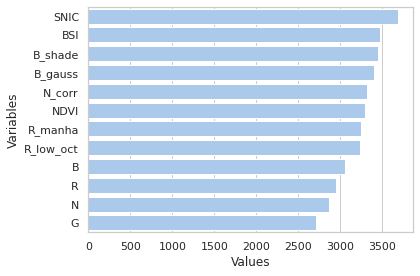

In [ ]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

var_dict = variable_importance.getInfo()

lists = sorted(var_dict['properties'].items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
var = [i[0] for i in lists]
values = [i[1] for i in lists]
d = pd.DataFrame({'Variables':var,'Values':values})

sns.barplot('Values', 'Variables', data = d, label="Variables", color="b")
plt.tight_layout()
plt.savefig("figures/RF_feature_imp.png", dpi=250)

####Validation

In [ ]:
validation = postFire_classified.sampleRegions(**{
  'collection': predicted_poly,
  'properties': ['class'],
  'scale': 100,
})

testAccuracy = validation.errorMatrix('class', 'classification');

In [ ]:
testAccuracy.array().getInfo()

EEException: ignored

In [ ]:
print("Test Accuracy: ", testAccuracy.accuracy().getInfo())
print("Kappa Accuracy: ", testAccuracy.kappa().getInfo())
print("Producer Accuracy: ", testAccuracy.producersAccuracy().getInfo())
print("Consumers Accuracy(): ", testAccuracy.consumersAccuracy().getInfo())

Test Accuracy:  0.8968799576943416
Kappa Accuracy:  0.5866842718202837
Producer Accuracy:  [[0.96875], [0.5479876160990712]]
Consumers Accuracy():  [[0.9123123123123124, 0.7831858407079646]]


#### Classification Visual

In [ ]:
boxcar = ee.Kernel.square(**{
  'radius': 2, 
  'units': 'pixels', 
  'magnitude': 1
});

smooth = postFire_classified.convolve(boxcar);

In [ ]:
class_palette = ['bff7ff','ff9900']

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
# Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_classified,
             {'palette': class_palette, 'min': 0, 'max':1},
             'postFire_classification')
# Map.addLayer(smooth, {'palette': class_palette, 'min': 0, 'max':1}, 'smoothed');
# Map.addLayer(visualizeByAttribute(predicted_poly, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'train')
Map.addLayerControl()
Map

In [ ]:
1